In [1]:
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import numpy as np
import sys
%matplotlib inline

In [2]:
def time_in_seconds(val):
    if "-" in val:
        fields = val.split("-")
        sec=0.0
        for i in fields:
            if "s" in i: sec += float(i.strip("s"))
            if "m" in i: sec += 60 * float(i.strip("m"))
            if "h" in i: sec += 3600 * float(i.strip("h"))
        return sec
    else:
        return float(val.strip("s"))

In [3]:
def parse_report(file_name):
    buffer = []
    resources_dict = {
        "MPI Cores": "mpi", "Threads per core": "thrs", "Threads total": "thr_tot", 
        "Nodes Computing": "nodes", "Nodes IO": "nodes_io", "MPI tasks / GPU": "mpi/gpu",
    }
    resources = {}
    timing = {}
    log = False
    with open(file_name, 'r') as report:
        for line in report:
            if line == "\n": log = False
            if log: 
                buffer.append(line.strip())
            else:
                for key, val in resources_dict.items():
                    if key in line: resources[val] = int(line.strip().split(":")[1])
                if "Time-Profile" in line:
                    timing["Time-Profile"] = time_in_seconds(line.strip().split(":")[1])

            if "Clock:" in line: log = True

    for line in buffer:
        fields = line.split(":")
        timing[fields[0].strip()] = time_in_seconds(fields[1].strip().split()[0])
    return resources, timing

In [4]:
def build_dataframe(x_axis='mpi', factor=1, rename_cols={}):
    r_files = glob("r-*")

    data = {}
    for report in r_files:
        resources, timing = parse_report(report)
        for key, val in resources.items():
            if key in data:
                data[key].append(val)
            else:
                data[key] = [val,]
        for key, val in timing.items():
            if key in data:
                data[key].append(val)
            else:
                data[key] = [val,]
    
    scaling = pd.DataFrame(data)
    if rename_cols: 
        scaling.rename(columns=rename_cols, inplace=True)
    else:
        scaling.rename(columns={'Xo (procedure)': 'Xo', 'X (procedure)': 'X'}, inplace=True)
    scaling.sort_values(by=[x_axis], inplace=True)
    if 'mpi/gpu' in scaling: scaling['gpu'] = pd.Series(scaling['mpi'] / scaling['mpi/gpu'], dtype=np.int64)
    scaling['ideal'] = scaling[x_axis] / factor
    scaling['speedup'] = scaling[scaling[x_axis]>=factor]['Time-Profile'].max() / scaling['Time-Profile']
    scaling['efficiency'] = scaling.speedup / scaling.ideal * 100
    scaling['Self energy'] = scaling['HF'] + scaling['GW(ppa)']
    scaling['Other'] = scaling['Time-Profile'] - scaling['Dipoles'] - scaling['Xo'] - scaling['X'] - scaling['Self energy']
    scaling['node_h'] = scaling['nodes'] * scaling['Time-Profile'] / 3600
    return scaling

In [5]:
def build_scaling_plot(scaling, pile, colors, x_axis='mpi', x_label='MPI tasks', bar_width=1,
                       title=None, legend_loc=None, label=None, label_pos=None, efficiency=True, 
                       file_name='scaling.png', y_lim=None):
    if len(pile) != len(colors):
        sys.stderr.write("Error: the number of elements of pile and colors lists have to be the same.")
        return
    fig, ax1 = plt.subplots(figsize=(10, 7))

    bottom = pd.Series(dtype='float64')
    for key, color in zip(pile, colors):
        if bottom.empty:
            ax1.bar(scaling[x_axis], scaling[key], width=bar_width, color=color, label=key)
            bottom = scaling[key].copy()
        else:
            ax1.bar(scaling[x_axis], scaling[key], width=bar_width, color=color, label=key, bottom=bottom)
            bottom += scaling[key]

    ax1.set_xlabel(x_label,fontsize=20)
    ax1.set_ylabel('Time (sec)',fontsize=20)
    ax1.legend()
    if y_lim: ax1.set_ylim(y_lim)
    if legend_loc: ax1.legend(fontsize='18',framealpha=0.0, loc=legend_loc)
    ax1.tick_params(axis = 'both', which = 'major', labelsize = 18)
    if label and label_pos: ax1.text(*label_pos, label, fontsize=20)
    plt.xticks(scaling[x_axis])
    
    if efficiency:
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_ylim([-10, 110])
        ax2.set_ylabel('Efficiency (%)', color='tab:blue',fontsize=20)  # we already handled the x-label with ax1
        ax2.plot(scaling[x_axis], scaling['efficiency'], linewidth=3, color='tab:blue')
        ax2.tick_params(axis='y', labelcolor='tab:blue', labelsize=18)
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    if title: plt.title(title, fontsize=20)
    plt.savefig(file_name, bbox_inches='tight')

In [6]:
def build_cost_plot(scaling, label='yambo', title=None, y_lim=None, file_name='cost.pdf'):
    fig2, ax3 = plt.subplots(figsize=(10, 7))
    ax3.set_xlabel('Time to solution (sec)',fontsize=20)
    ax3.set_ylabel('Cost (node*hour)',fontsize=20)
    ax3.plot(scaling['Time-Profile'][2:], scaling['node_h'][2:], 
             linewidth=3, color=colors[0], marker='.', markersize=15,
             label=label)
    if y_lim: ax3.set_ylim(y_lim)
    ax3.legend()
    ax3.legend(fontsize='18',framealpha=0.0)

    if title: plt.title(title, fontsize=20)
    plt.savefig(file_name)

In [7]:
scaling = build_dataframe(x_axis='mpi', factor=4)
scaling.to_csv('scaling.csv', sep='\t')
scaling

mpi  thrs  thr_tot  nodes  nodes_io  mpi/gpu  Time-Profile  \
12    4     8       32      1         1        1        4260.0   
6     8     8       64      2         1        1        2276.0   
8    12     8       96      3         1        1        1572.0   
9    16     8      128      4         1        1        1196.0   
5    20     8      160      5         1        1         974.0   
1    40     8      320     10         1        1         522.0   
2    60     8      480     15         1        1         375.0   
7    80     8      640     20         1        1         293.0   
3   100     8      800     25         1        1         245.0   
10  120     8      960     30         1        1         221.0   
11  140     8     1120     35         1        1         188.0   
0   160     8     1280     40         1        1         173.0   
4   200     8     1600     50         1        1         146.0   

    io_ATMPROJ_pwscf  io_KB_abinit   io_BS  ...         Xo  DIPOLE_transverse  \
12            0.0001        0.0001  0.0001  ...  1026.0000          2921.0000   
6             0.0000        0.0000  0.0001  ...   611.0000          1475.0000   
8             0.0001        0.0001  0.0001  ...   436.3983           997.0000   
9             0.0001        0.0000  0.0001  ...   347.1307           741.0000   
5             0.0000        0.0001  0.0001  ...   284.0948           599.1888   
1             0.0000        0.0001  0.0001  ...   160.4103           307.5391   
2             0.0001        0.0001  0.0001  ...   112.7530           210.5644   
7             0.0001        0.0001  0.0009  ...    87.1206           162.0953   
3             0.0001        0.0001  0.0001  ...    68.6395           132.8757   
10            0.0000        0.0001  0.0002  ...    62.4356           113.3480   
11            0.0001        0.0001  0.0002  ...    52.2781            98.1572   
0             0.0001        0.0001  0.0002  ...    45.8450            88.2307   
4             0.0001        0.0001  0.0002  ...    39.0437            74.7890   

      Dipoles  gpu  ideal    speedup  efficiency  Self energy    Other  \
12  2923.0000    4    1.0   1.000000  100.000000     320.4644 -14.9833   
6   1478.0000    8    2.0   1.871705   93.585237     164.5237  21.7836   
8   1001.0000   12    3.0   2.709924   90.330789     115.0157  17.3461   
9    744.0000   16    4.0   3.561873   89.046823      81.6177  17.7984   
5    601.0000   20    5.0   4.373717   87.474333      66.5503  21.7079   
1    310.9074   40   10.0   8.160920   81.609195      33.5243  16.4705   
2    214.9567   60   15.0  11.360000   75.733333      24.0247  18.3618   
7    168.3167   80   20.0  14.539249   72.696246      17.9534  18.9285   
3    138.1504  100   25.0  17.387755   69.551020      14.5203  22.9894   
10   123.6592  120   30.0  19.276018   64.253394      12.2702  21.8671   
11   105.8131  140   35.0  22.659574   64.741641      11.4922  17.6693   
0     94.3422  160   40.0  24.624277   61.560694      10.0520  22.0496   
4     78.8845  200   50.0  29.178082   58.356164       8.7866  18.5766   

      node_h  
12  1.183333  
6   1.264444  
8   1.310000  
9   1.328889  
5   1.352778  
1   1.450000  
2   1.562500  
7   1.627778  
3   1.701389  
10  1.841667  
11  1.827778  
0   1.922222  
4   2.027778  

[13 rows x 52 columns]

In [8]:
colors=['#2EA6A6', '#F28F38', '#47AB6C', '#112F41', '#D90718']
pile = ['Dipoles', 'Xo', 'X', 'Self energy', 'Other']
scaling[['mpi', 'Time-Profile'] + pile]

mpi  Time-Profile    Dipoles         Xo       X  Self energy    Other
12    4        4260.0  2923.0000  1026.0000  5.5189     320.4644 -14.9833
6     8        2276.0  1478.0000   611.0000  0.6927     164.5237  21.7836
8    12        1572.0  1001.0000   436.3983  2.2399     115.0157  17.3461
9    16        1196.0   744.0000   347.1307  5.4532      81.6177  17.7984
5    20         974.0   601.0000   284.0948  0.6470      66.5503  21.7079
1    40         522.0   310.9074   160.4103  0.6875      33.5243  16.4705
2    60         375.0   214.9567   112.7530  4.9038      24.0247  18.3618
7    80         293.0   168.3167    87.1206  0.6808      17.9534  18.9285
3   100         245.0   138.1504    68.6395  0.7004      14.5203  22.9894
10  120         221.0   123.6592    62.4356  0.7679      12.2702  21.8671
11  140         188.0   105.8131    52.2781  0.7473      11.4922  17.6693
0   160         173.0    94.3422    45.8450  0.7112      10.0520  22.0496
4   200         146.0    78.8845    39.0437  0.7086       8.7866  18.5766

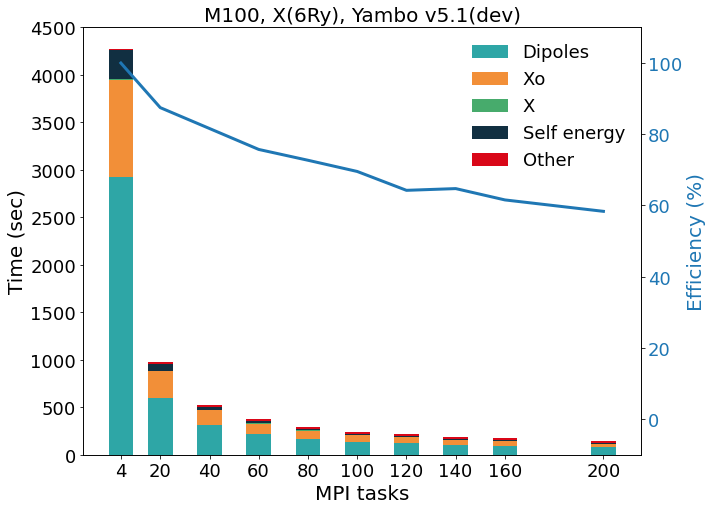

In [12]:
build_scaling_plot(scaling=scaling[(scaling['mpi']==4) | (scaling['mpi']>=20)], 
                   pile=pile, colors=colors, bar_width=10, efficiency=True,
                   legend_loc='upper right', title=r'M100, X(6Ry), Yambo v5.1(dev)', 
                   file_name='scaling_1nodes.png', y_lim=[0,4500])

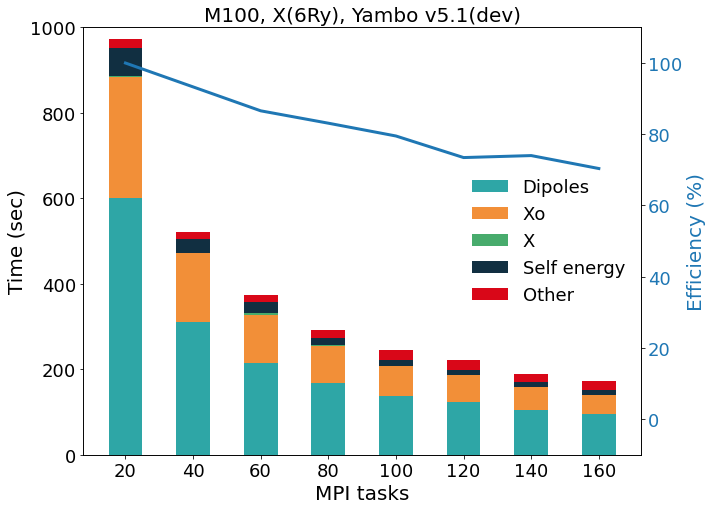

In [22]:
build_scaling_plot(scaling=scaling[(scaling['mpi']>=20) & (scaling['mpi']<=160)], 
                   pile=pile, colors=colors, bar_width=10, efficiency=True,
                   legend_loc='center right', title=r'M100, X(6Ry), Yambo v5.1(dev)', 
                   file_name='scaling_5nodes.png', y_lim=[0,1000])

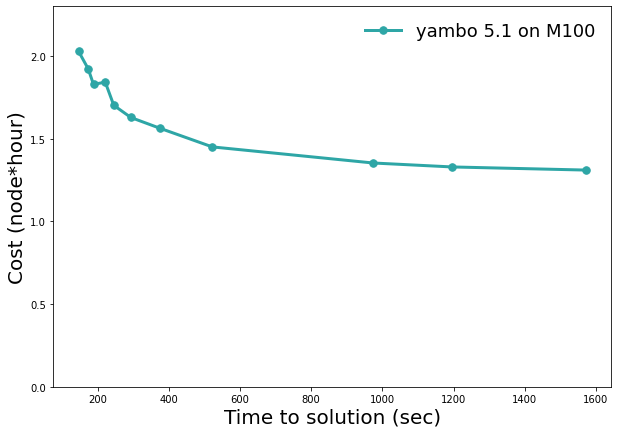

In [10]:
build_cost_plot(scaling=scaling, label='yambo 5.1 on M100', y_lim=[0,2.3])

In [8]:
scaling.columns

Index(['mpi', 'thrs', 'thr_tot', 'nodes', 'nodes_io', 'mpi/gpu',
       'Time-Profile', 'io_ATMPROJ_pwscf', 'io_KB_abinit', 'io_BS',
       'io_Double_Grid', 'io_COL_CUT', 'GW(REDUX)', 'PP_uspp_init', 'io_HF',
       'IO_and_Messaging_switch', 'HF(REDUX)', 'io_QINDX', 'scatter_Gamp_gpu',
       'io_QP_and_GF', 'io_GROT', 'io_X',
       'MATRIX transfer (X_G_finite_q_X_redux_2_2)',
       'MATRIX transfer (X_G_finite_q_X_redux_2_1)',
       'MATRIX transfer (X_G_finite_q_X_redux_1_2)',
       'MATRIX transfer (X_G_finite_q_X_redux_1_1)', 'io_KB_pwscf',
       'FFT_setup', 'SERIAL_lin_system_gpu', 'LINEAR ALGEBRA', 'X (REDUX)',
       'X', 'Xo (REDUX)', 'io_DIPOLES', 'RIM', 'io_fragment', 'io_WF', 'HF',
       'WF_load_FFT', 'XC_potential_driver', 'XCo_local', 'GW(ppa)', 'Xo',
       'DIPOLE_transverse', 'Dipoles', 'gpu', 'ideal', 'speedup', 'efficiency',
       'Self energy', 'Other', 'node_h'],
      dtype='object')

In [13]:
io_cols=['mpi', 'io_ATMPROJ_pwscf', 'io_KB_abinit', 'io_BS', 'io_Double_Grid', 'io_COL_CUT', 'PP_uspp_init', 'io_HF', 'IO_and_Messaging_switch', 'io_QINDX', 'io_KB_pwscf', 'io_DIPOLES', 'io_fragment', 'io_WF']
scaling[(scaling['mpi']>=20)&(scaling['mpi']<=160)][io_cols]

mpi  io_ATMPROJ_pwscf  io_KB_abinit   io_BS  io_Double_Grid  io_COL_CUT  \
5    20            0.0000        0.0001  0.0001          0.0003      0.0348   
1    40            0.0000        0.0001  0.0001          0.0002      0.0003   
2    60            0.0001        0.0001  0.0001          0.0008      0.0002   
7    80            0.0001        0.0001  0.0009          0.0003      0.0403   
3   100            0.0001        0.0001  0.0001          0.0003      0.0241   
10  120            0.0000        0.0001  0.0002          0.0003      0.0114   
11  140            0.0001        0.0001  0.0002          0.0002      0.0148   
0   160            0.0001        0.0001  0.0002          0.0003      0.0006   

    PP_uspp_init   io_HF  IO_and_Messaging_switch  io_QINDX  io_KB_pwscf  \
5         0.0006  0.0305                   0.0005    0.0350       0.3812   
1         0.0006  0.0139                   0.0006    0.0227       0.5616   
2         0.0006  0.0167                   0.0006    0.0139       0.4463   
7         0.0007  0.0159                   0.0006    0.0129       0.3908   
3         0.0007  0.0151                   0.0006    0.0156       0.2988   
10        0.0006  0.0120                   0.0006    0.3863       0.1732   
11        0.0007  0.0132                   0.0006    0.0054       0.2178   
0         0.0007  0.0185                   0.0006    0.0177       0.3632   

    io_DIPOLES  io_fragment   io_WF  
5       1.4228       1.6172  9.6665  
1       1.4797       2.3180  6.5893  
2       1.5066       1.9728  5.8259  
7       1.2174       1.6448  5.2362  
3       1.4333       1.6323  4.1469  
10      1.3085       1.2431  3.1075  
11      1.3823       2.0223  3.4569  
0       1.4472       1.9991  3.3781